In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import Tuple, Dict
from enum import Enum
from itertools import product

# Cliff Walking

We need an agent to move from a starting position to an ending position avoiding a cliff. 
- Each step has a reward of -1
- Moving on the cliff area has a reward of -100 and brings the agent immediately in the starting position.

We solve this problem by letting the agent learn using **Temporal Difference (TD)** methods, in particular **SARSA**, which is an *on-policy* method, and **Q-learning**, which is an *off-policy* method.

First of all we create the cliff:

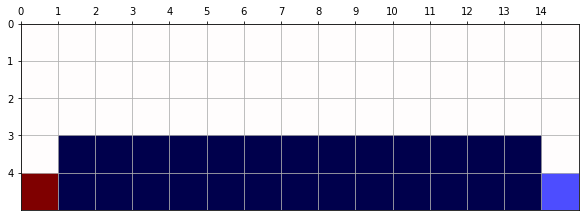

In [71]:
GRID_SIZE = (5, 15) # 5 rows, 15 columns
THE_CLIFF = [(3, 1), (5, 14)]

INITIAL_POSITION = (4,0) # In numpy coordinates
END_POSITION = (4,14)

START_VALUE = 2
END_VALUE = -0.7
CLIFF_VALUE = -2

GRID = np.zeros(GRID_SIZE)
GRID[INITIAL_POSITION] = START_VALUE
GRID[END_POSITION] = END_VALUE
GRID[THE_CLIFF[0][0]:THE_CLIFF[1][0], THE_CLIFF[0][1]:THE_CLIFF[1][1]] = CLIFF_VALUE

def draw_cliff_gridworld():
    fig, ax = plt.subplots(1,1,figsize=(10,14))
    ax.set_xlim(0, GRID_SIZE[1])
    ax.set_ylim(GRID_SIZE[0],0)
    ax.set_xticks(list(range(GRID_SIZE[1])))
    ax.set_yticks(list(range(GRID_SIZE[0])))
    ax.imshow(GRID, extent=(0, GRID_SIZE[1], GRID_SIZE[0], 0), cmap='seismic')
    ax.grid(True, 'major', 'both')
    ax.xaxis.tick_top()
    plt.show()

draw_cliff_gridworld()

The dark blue area is the cliff, while the start and end positions are the red and light blue squares.

The agent can move in all 4 directions:

In [3]:
class Action(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

We can say that states are the poisitions on the grid of the agent, so in total there are $W \times H \times 4$ state-action pairs.

The reward is -1 for any move, except for moves that lead into the cliff. Those moves also bring the agent back to the beginning. Moves that bring the agent out of bounds are also penalized with a -20 and not executed (i.e. the state remains the same).

In [48]:
st_0 = INITIAL_POSITION

def in_bounds(y,x):
    return 0 <= x < GRID_SIZE[1] and 0 <= y < GRID_SIZE[0]

def in_cliff(y,x):
    return THE_CLIFF[0][0] <= y < THE_CLIFF[1][0] and \
        THE_CLIFF[0][1] <= x < THE_CLIFF[1][1]

def reached_target(st1):
    return st1 == END_POSITION

def get_reward(st, a, st1):
    # Rewards for cliff are managed externally
    if st == st1:
        # Agent tried to go of bounds
        return -20
    elif reached_target(st1):
        # Agent reached the ending position
        return 0
    else:
        # Intermediate action
        return -1

def execute_action(st:Tuple, action:Action):
    if action == Action.UP:
        st_1 = (st[0]-1, st[1])
    elif action == Action.DOWN:
        st_1 = (st[0]+1, st[1])
    elif action == Action.LEFT:
        st_1 = (st[0], st[1]-1)
    elif action == Action.RIGHT:
        st_1 = (st[0], st[1]+1)
    if not in_bounds(*st_1):
        # Discard action
        st_1 = st
    if in_cliff(*st_1):
        # Bring agent to beginning
        st_1 = INITIAL_POSITION
        # Reward is exceptional: it's -100
        rt = -100
    else:
        rt = get_reward(st, action, st_1)
    return st_1, rt

## SARSA

One way we can obtain the optimal policy for the problem is to use SARSA, which is an on-policy control method (meaning that the policy that decides the action, so the exploitation policy, is also the policy that is used for updating the Q-values, so the exploration policy). We implement it here:

In [73]:
def choose_e_greedy_A_from_Q(S, Q, epsilon) -> Action:
    # Check if we take a random action according to epsilon
    if np.random.random() < epsilon:
        return np.random.choice(Action)
    # Otherwise, be greedy wrt Q
    return get_greedy_A_from_Q(S, Q)

def get_greedy_A_from_Q(S, Q) -> Action:
    q_values = {a: Q[(S[0],S[1],a)] for a in Action}
    # Choose maximum and randomly break ties
    best_action = max(q_values.keys(), key = lambda x: q_values[x])
    return best_action

def SARSA_cliff_gridworld(episodes=10000, step_size=0.7, discount=1, 
        epsilon=0.1, verbose=False):
    # Initialize starting q value arbitrarily except for ending position,
    # where Q(terminal, .) = 0
    initial_q_value = {
        (sy, sx, a): np.random.random()   
            for sx in range(GRID_SIZE[1]) 
            for sy in range(GRID_SIZE[0])
            for a in Action
            if (sy, sx) != END_POSITION
    }
    for end in [tuple(list(END_POSITION) + [a]) for a in Action]:
        initial_q_value[end] = 0
    Q = initial_q_value

    # Loop for each episode
    for ep in range(episodes):
        # Initialize S
        S = INITIAL_POSITION
        # Choose first action A with e-greedy policy from Q
        A = choose_e_greedy_A_from_Q(S, Q, epsilon)
        while not S == END_POSITION: # While we are not in the terminal state
            if verbose:
                print(f"At {S}, do {A}")
            # Execute A and obtain the new state and reward
            S_1, R = execute_action(S, A)
            # Execute the action at the following step using the same e-greedy policy
            A_1 = choose_e_greedy_A_from_Q(S_1, Q, epsilon)
            # We have the whole transition: S A R S_1 A_1
            # It's time to update Q
            index = tuple(list(S) + [A])
            next_index = tuple(list(S_1) + [A_1])
            error = R + discount*Q[next_index] - Q[index]
            Q[index] += step_size*error
            if verbose:
                print(f"     --> get {R}, go in {S_1} where selects {A_1}")
                print(f"         error: {error}")
            # Change state
            S = S_1
            # Select next action
            A = A_1 
    
    return Q

q = SARSA_cliff_gridworld(episodes=100000)

Here, we use a function to display the optimal path following the obtained q-values.

In [74]:
def play_using_q(Q):
    states = []
    actions = []
    S = INITIAL_POSITION
    A = choose_e_greedy_A_from_Q(S, Q, epsilon=0)
    while not S == END_POSITION:
        states.append(S)
        actions.append(A)
        S, _ = execute_action(S, A)
        A = choose_e_greedy_A_from_Q(S, Q, epsilon=0)
    states.append(S)
    return states, actions

states, actions = play_using_q(q)

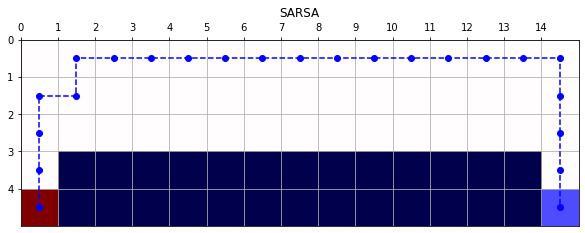

In [75]:
def draw_movements(states, title='GRAPH'):
    def get_center(s):
        return s[0] + 0.5, s[1] + 0.5
    fig, ax = plt.subplots(1,1,figsize=(10,14))
    ax.set_xlim(0, GRID_SIZE[1])
    ax.set_ylim(GRID_SIZE[0],0)
    ax.set_xticks(list(range(GRID_SIZE[1])))
    ax.set_yticks(list(range(GRID_SIZE[0])))
    ax.imshow(GRID, extent=(0, GRID_SIZE[1], GRID_SIZE[0], 0), cmap='seismic')
    xs = []; ys = []
    for s in states:
        y, x = get_center(s); xs.append(x); ys.append(y)
    ax.plot(xs, ys, 'bo--')
    ax.grid(True, 'major', 'both')
    ax.xaxis.tick_top()
    plt.title(title)
    plt.show()

draw_movements(states, title='SARSA')

The agent is mindful of the actions he is going to take next, so he keeps away from the cliff.

## Q-learning

Q-learning is an alternative: it's an **off-policy** control technique where the agent updates its value based not on its policy but on a greedy decision on its current Q estimate.

In [76]:
def Q_learning_cliff_gridworld(episodes=10000, step_size=0.7, discount=1, 
        epsilon=0.1, verbose=False):
    # Initialize starting q value arbitrarily except for ending position,
    # where Q(terminal, .) = 0
    initial_q_value = {
        (sy, sx, a): np.random.random()   
            for sx in range(GRID_SIZE[1]) 
            for sy in range(GRID_SIZE[0])
            for a in Action
            if (sy, sx) != END_POSITION
    }
    for end in [tuple(list(END_POSITION) + [a]) for a in Action]:
        initial_q_value[end] = 0
    Q = initial_q_value

    # Loop for each episode
    for ep in range(episodes):
        # Initialize S
        S = INITIAL_POSITION
        while not S == END_POSITION: # While we are not in the terminal state
            # Choose first action A with e-greedy policy from Q
            A = choose_e_greedy_A_from_Q(S, Q, epsilon)
            if verbose:
                print(f"At {S}, do {A}")
            # Execute A and obtain the new state and reward
            S_1, R = execute_action(S, A)
            # THIS IS THE PART THAT IS DIFFERENT FROM SARSA:
            # Obtain the best action at S_1 based on the current estimate of Q
            A_1 = get_greedy_A_from_Q(S, Q)
            # It's time to update Q
            index = tuple(list(S) + [A])
            next_index = tuple(list(S_1) + [A_1])
            error = R + discount*Q[next_index] - Q[index]
            Q[index] += step_size*error
            if verbose:
                print(f"     --> get {R}, go in {S_1} where best action is {A_1}")
                print(f"         error: {error}")
            # Change state
            S = S_1
            # Select next action
            A = A_1 
    
    return Q

q_off = Q_learning_cliff_gridworld(episodes=100000)

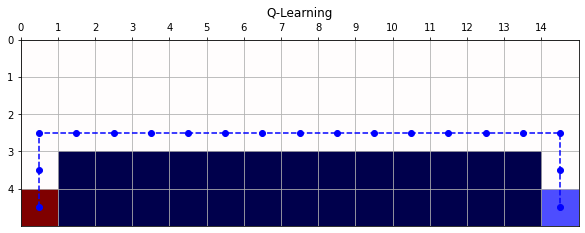

In [77]:
states, actions = play_using_q(q_off)
draw_movements(states, title='Q-Learning')

Here the agent does not care about which actions it's going to do next, so he blindly goes for the fastest path that runs at the limit of the cliff, even though with its policy, especially with the stochastic element of $\epsilon$-greedy, the next move may be at any time to fall into the cliff. 

Depending on the application, one could prefer SARSA or Q-Learning as a control method.